# SSD7 Training Tutorial

Almost all this training code is from the link provided in the README.
Let's important everything we will need.

In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

Using TensorFlow backend.
/datasets/home/home-03/83/183/jkadifa/Project/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


## 1. Set the model configuration parameters

Set our parameters for model building.

In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

## 2 Create a new model


In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

#import torch
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(device)
#model = model.to(device)

## 3. Set up the data generators for the training

Set the file locations of the images and training/validation files. Also perform data augmentation.

In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = 'dataset/udacity_driving_datasets'

# Ground truth
train_labels_filename = 'dataset/udacity_driving_datasets/labels_train.csv'
val_labels_filename   = 'dataset/udacity_driving_datasets/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_train.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_val.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Creating HDF5 dataset: 100%|██████████| 4241/4241 [00:26<00:00, 162.92it/s]
Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [5]:
# 3: Set the batch size.

batch_size = 4 #16

# 4: Define the image processing chain.

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

## 4. Set the remaining training parameters and train the model


In [6]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [7]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 10 #20
steps_per_epoch = 100  #1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/10
100/100 [==============================] - 690s 7s/step - loss: 9.1100 - val_loss: 6.5504

Epoch 00001: val_loss improved from inf to 6.55044, saving model to ssd7_epoch-01_loss-9.1100_val_loss-6.5504.h5
Epoch 2/10
100/100 [==============================] - 664s 7s/step - loss: 4.6942 - val_loss: 4.3236

Epoch 00002: val_loss improved from 6.55044 to 4.32361, saving model to ssd7_epoch-02_loss-4.6942_val_loss-4.3236.h5
Epoch 3/10
100/100 [==============================] - 656s 7s/step - loss: 3.9312 - val_loss: 3.8965

Epoch 00003: val_loss improved from 4.32361 to 3.89647, saving model to ssd7_epoch-03_loss-3.9312_val_loss-3.8965.h5
Epoch 4/10
100/100 [==============================] - 623s 6s/step - loss: 3.7233 - val_loss: 3.7615

Epoch 00004: val_loss improved from 3.89647 to 3.76148, saving model to ssd7_epoch-04_loss-3.7233_val_loss-3.7615.h5
Epoch 5/10
100/100 [==============================] - 622s 6s/step - loss: 3.8062 - val_loss: 3.7079

Epoch 00005: val_loss impr

Optional to plot our validation and training losses:

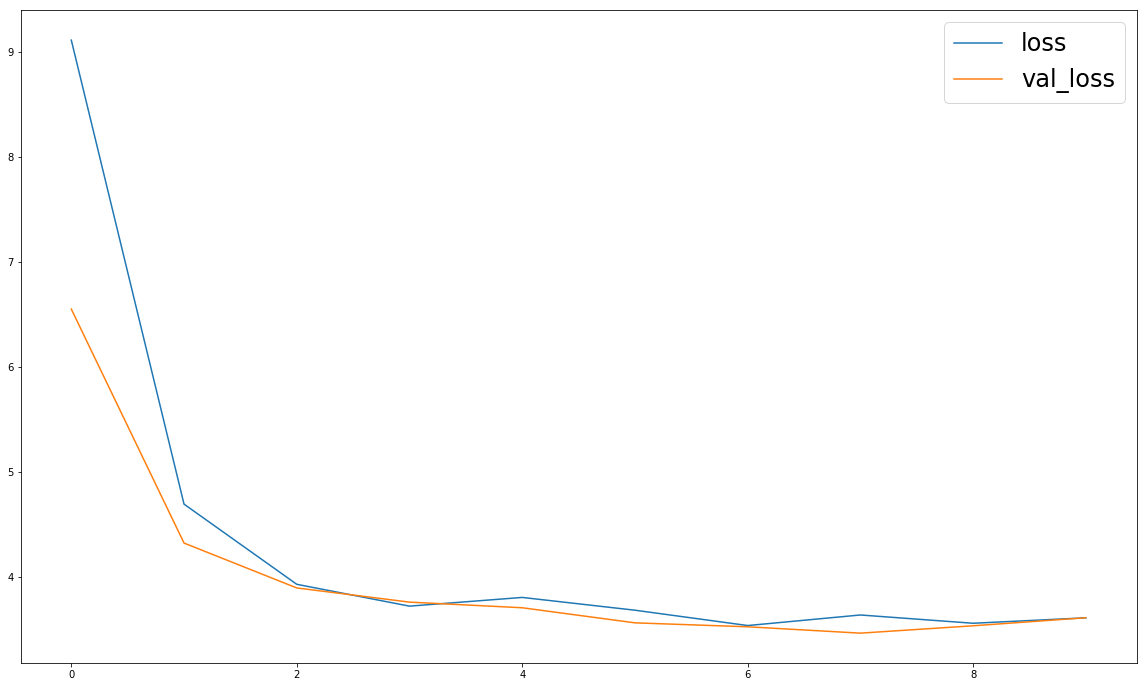

In [8]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});